# Identitas & Definisi Hasil Pekerjaan
## Ivan Budianto

### shinsuketenma0603@gmail.com
### Submission Machine Learning Terapan 2

## Sistem Rekomendasi Judul Anime 

### Metode:
- Collaborative filtering
- Hypertuning menggunakan SGD optimizer & learning rate

Melakukan import library yang dibutuhkan (Pandas, Numpy, Tensorflow)

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

import os

# Pre-Processing

## Berikut adalah langkah-langkah yang saya lakukan dalam proses preprocessing data:
1. Memasukkan dataset data review user 
2. Melakukan filtering data untuk mencari hanya user yang sudah menonton (mereview tentunya) setidaknya 500 anime 
3. Melakukan filtering data duplikat
4. Scaling dataset pada rating menggunakan minmaxscaler
5. Encode anime dan user
6. Proses shuffling dan pendefinisian fitur (x dan y)
7. Proses split dataset
8. Ekstrak fitur berupa parameter untuk melakukan pemodelan

## Memasukkan dataset data review user 
Dari dataset mengenai rating anime oleh user, hanya menggunakan beberapa kolom saja (slicing) pada kolom user_id, anime_id, dan rating pengguna untuk setiap anime.

In [5]:
#mendefinisikan base_dir, dan memasukkan dataset

base_dir = "C:/Users/xcessive/Documents/machine_learning"

df_raw = pd.read_csv(os.path.join(base_dir, 'animelist.csv'),
                     usecols=["user_id", "anime_id", "rating"])

df_raw.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


## Melakukan filtering data untuk mencari hanya user yang sudah menonton (mereview tentunya) setidaknya 500 anime 
Dari dataset yang telah diimport, sekarang akan dilakukan filtering untuk mencari user-user yang telah mereview setidaknya 500 anime, dan meletakkan data tersebut pada user_rating_df.

In [6]:
#filtering data user

n_ratings = df_raw['user_id'].value_counts()
user_rating_df = df_raw[df_raw['user_id'].isin(n_ratings[n_ratings >= 500].index)].copy()

## Melakukan filtering data duplikat
Duplikasi data akan menyebabkan hasil dari sistem rekomendasi menjadi "offside". Maka dari itu, perlu dilakukan filtering pada dataset yang digunakan pada data yang duplikat atau sama.

In [7]:
#filtering data duplikat

duplicates = user_rating_df.duplicated()
user_rating_df = user_rating_df[~duplicates]

In [8]:
print("User in use: {}".format(len(df_raw['user_id'].unique())))

User in use: 325770


## Scaling dataset pada rating menggunakan minmaxscaler
Dataset yang besar, dan memiliki range yang tinggi akan menyulitkan algoritma dalam melakukan tugasnya (membuat rekomendasi). Dengan penggunaan MinMaxScaler dari sklearn, akan memudahkan dalam melakukan pemrosesan data. Kolom yang akan discaling adalah kolom rating.

In [9]:
# scaling dataset

minmax_scaler = MinMaxScaler()
user_rating_df[["rating"]] = minmax_scaler.fit_transform(user_rating_df[["rating"]])

user_rating_df

,user_id,anime_id,rating
1415,6,9062,0.8
1416,6,9919,0.0
1417,6,150,0.7
1418,6,4981,0.0
1419,6,10793,0.0
...,...,...,...
109224268,353398,34086,0.0
109224269,353398,17909,0.0
109224270,353398,32924,0.0
109224271,353398,24627,0.0


## Encode anime dan user
Proses encode akan memudahkan program dalam mengidentifikasi setiap data yang ada. Melalui proses encode ini, program dapat dengan mudah mengenali setiap user dan anime yang ada melalui bilangan numerik, sehingga pemrosesan data dapat dilakukan dengan lebih efisien.

In [10]:
user_ids = user_rating_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
user_rating_df["user"] = user_rating_df["user_id"].map(user2user_encoded)
n_users = len(user2user_encoded)

anime_ids = user_rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime_encoded2anime = {i: x for i, x in enumerate(anime_ids)}
user_rating_df["anime"] = user_rating_df["anime_id"].map(anime2anime_encoded)
n_animes = len(anime2anime_encoded)

print("Num of users: {}, Num of animes: {}".format(n_users, n_animes))
print("Min rating: {}, Max rating: {}".format(min(user_rating_df['rating']), max(user_rating_df['rating'])))

Num of users: 66698, Num of animes: 17560
Min rating: 0.0, Max rating: 1.0


## Proses shuffling dan pendefinisian fitur (x dan y)

Melakukan shuffling dari data pada dataset untuk menghindari overfitting dari model. Dengan melakukan shuffling, model akan belajar dengan lebih "obyektif"

Mendefinisikan X dan y, dimana:
- X merupakan data yang menjadi tolok ukur untuk prediksi (data dari dataset)
- y merupakan hasil atau tujuan dari hasil prediksinya

In [11]:
#shuffle data

user_rating_df = user_rating_df.sample(frac=1, random_state=73)

X = user_rating_df[['user', 'anime']].values
y = user_rating_df["rating"]

## Proses split dataset
Sebagai persiapan sebelum melakukan pemodelan, perlu dilakukan pemisahan dataset train dan test. Pemisahan ini berguna untuk melakukan validasi keakuratan dari data yang telah ditraining. Dalam kasus kali ini, saya memisahkan dataset test sebanyak 20ribu data, dan data sisanya merupakan dataset traning.

Pemisahkan antara dataset latihan (train) dan 
dataset test (test) dengan pembagian:
- 20000 (20ribu) dataset pengujian (test set)
- sisanya merupakan dataset latihan (train set)

In [12]:
# Split
test_set = 20000
train_indices = user_rating_df.shape[0] - test_set 

X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

## Ekstrak fitur berupa parameter untuk melakukan pemodelan
Dalam melakukan pelatihan model, tentu dibutuhkan sebuah data yang digunakan untuk melakukan pelatihan.

In [13]:
X_train_params = [X_train[:, 0], X_train[:, 1]]
X_test_params = [X_test[:, 0], X_test[:, 1]]

# Modelling

Pembuatan model menggunakan 2 metode, yaitu:
- Collaborative Filtering
- Pengembangan Model Pertama (Hypertuning Collaborative Filtering)

Berikut adalah langkah-langkah yang saya lakukan dalam proses modelling:
1. Instantiasi Model pertama
2. Membuat Callback untuk kedua model
3. Melakukan proses training pada model pertama
4. Hasil training, dan verdict #1
5. Menyimpan model (bobot hasil pelatihan) pertama pada JSON
6. Mendefinisikan model ke-2
7. Melakukan proses training pada model kedua
8. Hasil training, dan verdict #2
9. Menyimpan model (bobot hasil pelatihan) kedua pada JSON

## Mendefinisikan model & parameter yang digunakan pada model pertama
Mendefinisikan model, dan metode yang digunakan, yaitu model RecommenderNet pertama dari Tensoflow sebagai base dari model berikutnya. Model ini menggunakan parameter yang telah kita telusuri bersama sebelumnya pada parameter X untuk melakukan training dan testing.

Dalam model pertama, optimizer yang digunakan adalah Adam, dimana optimizer ini merupakan optimizer yang "all-round", dan dapat menyelesaikan hampir seluruh masalah dalam machine learning dengan baik. Maka dari itu, dipilih Adam sebagai optimizer pertama.

Metrik yang digunakan dalam pemodelan ini adalah mae dan mse, dimana dalam modul dicoding juga menggunakan metrik mse untuk melakukan training model serupa. Penjelasan lebih lanjut mengenai metrik evaluasi akan dijelaskan pada bagian evaluasi.

In [14]:
def RecommenderNet():
    embedding_size = 128
    
    user = tf.keras.layers.Input(name = 'user', shape = [1])
    user_embedding = tf.keras.layers.Embedding(name = 'user_embedding',
                       input_dim = n_users, 
                       output_dim = embedding_size)(user)
    
    anime = tf.keras.layers.Input(name = 'anime', shape = [1])
    anime_embedding = tf.keras.layers.Embedding(name = 'anime_embedding',
                       input_dim = n_animes, 
                       output_dim = embedding_size)(anime)
    
    res = tf.keras.layers.Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedding, anime_embedding])
    res = tf.keras.layers.Flatten()(res)
        
    res = tf.keras.layers.Dense(1, kernel_initializer='he_normal')(res)
    res = tf.keras.layers.BatchNormalization()(res)
    res = tf.keras.layers.Activation("sigmoid")(res)
    
    model = tf.keras.models.Model(inputs=[user, anime], outputs=res)
    model.compile(loss='binary_crossentropy', metrics=["mae", "mse"], optimizer='Adam')
    
    return model

## Instantiasi Model pertama

Dari model RecommenderNet yang telah berhasil dicompile, berikut adalah proses instantiasi dari model pertama dengan memanggil model tersebut.

In [15]:
model = RecommenderNet()

## Membuat Callback untuk kedua model

Callback yang digunakan disini adalah callback bawaan dari Keras, yaitu Early Stopping. Early Stopping, seperti namanya, akan menghentikan proses converge model yang sedang dilatih lebih cepat dari seharusnya. Penghentian ini akan bergantung pada learning rate dari model pada beberapa epoch. Bila epoch dirasa "merugikan" dari sisi akurasi yang tidak bertambah, atau malah berkurang, maka proses training akan dihentikan.

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 3, monitor='val_loss', 
                               mode='min', restore_best_weights=True)

## Melakukan proses training pada model pertama
Melakukan proses training (fitting) pada model pertama menggunakan dataset yang telah didefinisikan. Proses ini dilakukan menggunakan syntax fit pada model.

In [17]:
# Model training
history = model.fit(
    x=X_train_params,
    y=y_train,
    batch_size=10000,
    epochs=20,
    verbose=1,
    validation_data=(X_test_params, y_test),
    callbacks=early_stopping
)

Epoch 1/20
6027/6027 [==============================] - 661s 109ms/step - loss: 0.5269 - mae: 0.2276 - mse: 0.0864 - val_loss: 0.4853 - val_mae: 0.1950 - val_mse: 0.0714
Epoch 2/20
6027/6027 [==============================] - 640s 106ms/step - loss: 0.4720 - mae: 0.1829 - mse: 0.0654 - val_loss: 0.4744 - val_mae: 0.1859 - val_mse: 0.0678
Epoch 3/20
6027/6027 [==============================] - 646s 107ms/step - loss: 0.4561 - mae: 0.1714 - mse: 0.0595 - val_loss: 0.4714 - val_mae: 0.1819 - val_mse: 0.0663
Epoch 4/20
6027/6027 [==============================] - 659s 109ms/step - loss: 0.4477 - mae: 0.1653 - mse: 0.0564 - val_loss: 0.4701 - val_mae: 0.1797 - val_mse: 0.0660
Epoch 5/20
6027/6027 [==============================] - 660s 109ms/step - loss: 0.4425 - mae: 0.1613 - mse: 0.0545 - val_loss: 0.4714 - val_mae: 0.1788 - val_mse: 0.0663
Epoch 6/20
6027/6027 [==============================] - 658s 109ms/step - loss: 0.4387 - mae: 0.1585 - mse: 0.0531 - val_loss: 0.4710 - val_mae: 0.178

## Hasil training, dan verdict #1

Dari hasil training yang telah dilakukan, didapatkan hasil yang sangat baik, dimana mse sudah berada dibawah angka 0.05. Dari hasil pelatihan ini, model dapat melakukan prediksi dari data train dan test dengan cukup baik, dimana tidak ada perbedaan yang signifikan antara MAE & MSE pada train dan val.
Hasil yang baik juga dapat dilihat pada variabel loss, dimana loss pada proses training cenderung mengalami penurunan.

Untuk memperjelas hasil dari pelatihan ini, berikut adalah grafik plotting loss & val loss untuk model pertama.

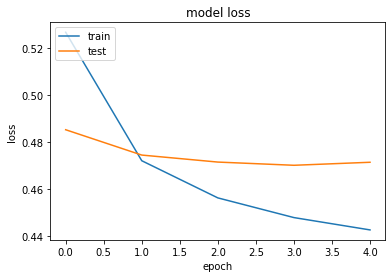

In [18]:
#Training results
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

## Menyimpan model (bobot hasil pelatihan) pertama pada JSON
Dengan melakukan penyimpanan bobot dari model yang telah dibuat, kita dapat mengakses model tersebut dengan akurasi yang sama tanpa perlu melakukan training kembali dan memiliki resiko untuk menghasilkan akurasi yang berbeda dari model sebelumnya. Untuk melakukan hal ini, kita hanya perlu mengimport modul model_from_json, dan mengeksekusi query berikut.

In [19]:
from keras.models import model_from_json

model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")
print("Model saved")

# #mengambil model
# json_file = open('model.json', 'r')
# saved_model = json_file.read()
# # close the file as good practice
# json_file.close()
# model_from_json = model_from_json(saved_model)
# # load weights into new model
# model_from_json.load_weights("model.h5")
# print("Model loaded")

Model saved


## Mendefinisikan model ke-2

Dalam model pertama, optimizer yang digunakan adalah Adam, dimana optimizer ini merupakan optimizer yang "all-round", dan dapat menyelesaikan hampir seluruh masalah dalam machine learning dengan baik. Maka dari itu, dipilih Adam sebagai optimizer pertama.

Dalam model kedua ini, algoritma yang digunakan merupakan hypertuning secara manual dengan menggunakan optimizer yang berbeda. Dengan menggunakan optimizer yang berbeda, kita dapat mendapatkan algoritma "berbeda". Disini, digunakan Stocasthic Gradient Descent atau SGD optimizer untuk melakukan optimizing pada model.
Selain itu, dalam model ini juga diubah parameter embedding_size menjadi 2x lipat dari model sebelumnya.

Metrik yang digunakan dalam pemodelan ini adalah mae dan mse, dimana dalam model sebelumnya juga menggunakan parameter yang sama. Penggunaan parameter yang sama ditujukan agar dalam pembuatan model dapat dinilai secara objektif dari kedua sisinya.

In [20]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)

def RecommenderNet():
    embedding_size = 256
    initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
    
    user = tf.keras.layers.Input(name = 'user', shape = [1])
    user_embedding = tf.keras.layers.Embedding(name = 'user_embedding',
                       input_dim = n_users, 
                       output_dim = embedding_size)(user)
    
    anime = tf.keras.layers.Input(name = 'anime', shape = [1])
    anime_embedding = tf.keras.layers.Embedding(name = 'anime_embedding',
                       input_dim = n_animes, 
                       output_dim = embedding_size)(anime)
    
    res = tf.keras.layers.Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedding, anime_embedding])
    res = tf.keras.layers.Flatten()(res)
    
    res = tf.keras.layers.Dense(1, kernel_initializer=initializer)(res)
    res = tf.keras.layers.BatchNormalization()(res)
    res = tf.keras.layers.Activation("sigmoid")(res)
    
    model = tf.keras.models.Model(inputs=[user, anime], outputs=res)
    model.compile(loss='binary_crossentropy', metrics=["mae", "mse"], optimizer=optimizer)
    
    return model

## Melakukan proses training pada model kedua
Melakukan proses training (fitting) pada model kedua menggunakan dataset yang sama. Proses ini dilakukan menggunakan syntax fit pada model.

In [21]:
# Model training 2
model_hyper = RecommenderNet()
history_hyper = model_hyper.fit(
    x=X_train_params,
    y=y_train,
    batch_size=10000,
    epochs=20,
    verbose=1,
    validation_data=(X_test_params, y_test),
    callbacks=early_stopping
)

Epoch 1/20
6027/6027 [==============================] - 313s 51ms/step - loss: 0.6998 - mae: 0.3669 - mse: 0.1595 - val_loss: 0.6736 - val_mae: 0.3645 - val_mse: 0.1485
Epoch 2/20
6027/6027 [==============================] - 311s 52ms/step - loss: 0.6734 - mae: 0.3643 - mse: 0.1472 - val_loss: 0.6711 - val_mae: 0.3647 - val_mse: 0.1473
Epoch 3/20
6027/6027 [==============================] - 312s 52ms/step - loss: 0.6729 - mae: 0.3645 - mse: 0.1469 - val_loss: 0.6709 - val_mae: 0.3648 - val_mse: 0.1472
Epoch 4/20
6027/6027 [==============================] - 316s 52ms/step - loss: 0.6728 - mae: 0.3646 - mse: 0.1469 - val_loss: 0.6709 - val_mae: 0.3648 - val_mse: 0.1472
Epoch 5/20
6027/6027 [==============================] - 317s 53ms/step - loss: 0.6728 - mae: 0.3646 - mse: 0.1469 - val_loss: 0.6709 - val_mae: 0.3648 - val_mse: 0.1472
Epoch 6/20
6027/6027 [==============================] - 293s 49ms/step - loss: 0.6728 - mae: 0.3646 - mse: 0.1469 - val_loss: 0.6709 - val_mae: 0.3648 - va

## Hasil training, dan verdict #2

Dari hasil training yang telah dilakukan, didapatkan hasil yang biasa saja, dimana mse sudah berada dibawah angka 0.5. Dari hasil pelatihan ini, model dapat melakukan prediksi dari data train dan test dengan cukup baik, dimana tidak ada perbedaan yang signifikan antara MAE & MSE pada train dan val.
Namun, bila dibandingkan dengan model pertama, ternyata pengembangan model menggunakan SGD tidak sebaik dengan menggunakan Adam. Dari sini, dapat dilihat melalui akurasi dari model yang didapat.

Untuk memperjelas hasil dari pelatihan ini, berikut adalah grafik plotting loss & val loss untuk model kedua.

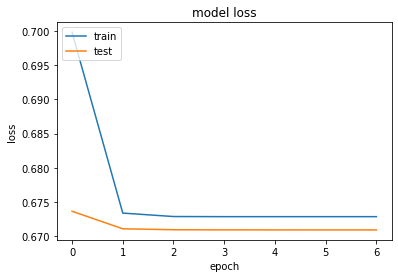

In [37]:
#Training results
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history_hyper.history["loss"][0:-2])
plt.plot(history_hyper.history["val_loss"][0:-2])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

## Menyimpan model (bobot hasil pelatihan) kedua pada JSON
Sama seperti proses sebelumnya, dilakukan penyimpanan bobot dari model kedua pada JSON.

In [42]:
from keras.models import model_from_json

model_hyper_json = model_hyper.to_json()

with open("model_hyper.json", "w") as json_file:
    json_file.write(model_hyper_json)

model_hyper.save_weights("model_hyper.h5")
print("Model saved")

# #mengambil model
# json_file = open('model_hyper.json', 'r')
# saved_model = json_file.read()
# # close the file as good practice
# json_file.close()
# model_from_json = model_from_json(saved_model)
# # load weights into new model
# model_from_json.load_weights("model_hyper.h5")
# print("Model loaded")

Model saved


# Exhibition rekomendasi anime
Dalam proses ini, kita akan melakukan ekstraksi hasil pelatihan dari model yang telah dibangun untuk memberikan N rekomendasi anime yang diinginkan oleh user. Dalam latihan ini, digunakan maksimal 10 anime sebagai rekomendasi untuk user setelah melakukan input berupa judul berbahasa inggris dari anime yang diinginkan.

Proses tersebut terdiri dari beberapa bagian, yaitu:
1. Mengambil bobot dari tiap anime yang berhasil ditraining
2. Mengambil data dari dataset anime kedalam dataframe baru
3. Mencari nama anime dari dataframe
4. Melakukan sorting dari skor, merapikan dataframe
5. Pengambilan metadata anime dari dataframe (df)
6. Mendefinisikan fungsi untuk eksekusi dari model #1
7. Mendefinisikan fungsi untuk eksekusi dari model #2
8. Testing model #1 untuk anime "Naruto" untuk menampilkan 10 anime termirip.
9. Testing model #2 untuk anime "Naruto" untuk menampilkan 10 anime termirip.

## Mengambil bobot dari tiap anime yang berhasil ditraining
Dari kedua model yang telah berhasil ditraining, hasil dari kedua traning berupa bobot akan diekstrak dari model untuk melakukan prediksi berupa pemberian rekomendasi kepada pengguna berdasarkan judul anime yang dimasukkan.

Terdapat 2 fungsi yang dibuat dalam tahap ini, yaitu:
- Fungsi extract_weights yang membutuhkan parameter berupa nama anime yang berasal dari model pertama
- Fungsi extract_weights_hyper yang membutuhkan parameter berupa nama anime yang berasal dari model kedua

In [23]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))

    return weights

anime_weights = extract_weights('anime_embedding', model)
user_weights = extract_weights('user_embedding', model)

In [24]:
def extract_weights_hyper(name, model_hyper):
    weight_layer = model_hyper.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))

    return weights

anime_weights_hyper = extract_weights_hyper('anime_embedding', model_hyper)
user_weights_hyper = extract_weights_hyper('user_embedding', model_hyper)

## Mengambil data dari dataset anime kedalam dataframe baru

Untuk memperlihatkan hasil yang dapat dinilai secara mudah, maka dibuatlah sebuah dataframe baru untuk menunjang pengambilan data.

In [39]:
df = pd.read_csv(base_dir + '/anime.csv', low_memory=True)
df = df.replace("Unknown", np.nan)

## Mencari nama anime dari dataframe

Untuk mendapatkan nama dari dataframe anime, dibutuhkan slicing pada kolom nama. Namun, karena terdapat judul yang merupakan hasil dari translate (misal "Shingeki no Kyojin" menjadi "Attack On Titan"), maka dibutuhkan nama anime yang universal. Maka dari itu, diambil judul inggris dari anime tersebut untuk dijadikan parameter baru.
Apabila tidak memiliki judul berbahasa inggris, maka judul original akan digunakan.

In [40]:
def get_anime_name(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print('error')
    
    return name

df['anime_id'] = df['MAL_ID']
df["eng_version"] = df['English name']
df['eng_version'] = df.anime_id.apply(lambda x: get_anime_name(x))

In [41]:
df.head(5)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,6,Trigun
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, Magic",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7,Witch Hunter Robin
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,8,Beet the Vandel Buster


## Melakukan sorting dari skor, merapikan dataframe

Dengan melakukan sorting judul anime berdasarkan skor tertinggi, akan memudahkan sistem dalam mencari anime yang memiliki skor tinggi yang cenderung direkomendasikan pada hasil dari rekomendasi sistem.
Setelah dilakukan sorting, saatnya untuk menampilkan anime yang diinginkan, beserta key dalam mencari anime (yaitu anime_id sebagai tolok ukur pencarian anime, dan eng_version merupakan judul dari anime rekomendasi)

In [28]:
df.sort_values(by=['Score'], 
               inplace=True,
               ascending=False,
               na_position='last')

df = df[["anime_id", "eng_version", 
         "Score","Genres","Episodes", 
         "Type", "Premiered", "Members"]]

In [29]:
df

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121
...,...,...,...,...,...,...,...,...
17557,48481,Daomu Biji Zhi Qinling Shen Shu,NaN,"Adventure, Mystery, Supernatural",NaN,ONA,NaN,354
17558,48483,Mieruko-chan,NaN,"Comedy, Horror, Supernatural",NaN,TV,NaN,7010
17559,48488,Higurashi:When They Cry – SOTSU,NaN,"Mystery, Dementia, Horror, Psychological, Supe...",NaN,TV,Summer 2021,11309
17560,48491,Yama no Susume: Next Summit,NaN,"Adventure, Slice of Life, Comedy",NaN,TV,NaN,1386


## Pengambilan metadata anime dari dataframe (df)

Dari data yang telah dimiliki, maka bila rekomendasi tersebut meminta anime_id tersebut, maka akan diberikan dataframe berdasarkan anime yang dibutuhkan, dan anime yang akan direkomendasikan.

In [30]:
def get_anime_frame(anime):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    if isinstance(anime, str):
        return df[df.eng_version == anime]

## Fungsi eksekusi dari model #1

Berikut adalah fungsi yang akan digunakan dalam menampilkan rekomendasi anime dari judul yang diinputkan untuk model #1.
Dengan memasukkan judul anime yang disukai, maka pengguna bisa mendapatkan rekomendasi dari sistem mengenai anime yang mirip (similiar).

In [31]:
pd.set_option("max_colwidth", None)

def find_similar_animes(name, n=10, return_dist=False, neg=False):
    try:
        index = get_anime_frame(name).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)
        weights = anime_weights
        
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        
        n = n + 1
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print('animes closest to {}'.format(name))

        if return_dist:
            return dists, closest
        
        rindex = df

        SimilarityArr = []

        for close in closest:
            decoded_id = anime_encoded2anime.get(close)
            anime_frame = get_anime_frame(decoded_id)
            
            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[close]
            SimilarityArr.append({"anime_id": decoded_id, "name": anime_name, "genres":genre,
                                  "similarity": similarity,})

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)

    except:
        print('{}!, Not Found in Anime list'.format(name))

## Fungsi eksekusi dari model #2

Berikut adalah fungsi yang akan digunakan dalam menampilkan rekomendasi anime dari judul yang diinputkan untuk model #2.
Dengan memasukkan judul anime yang disukai, maka pengguna bisa mendapatkan rekomendasi dari sistem mengenai anime yang mirip (similiar).

Fungsi ini hanya disediakan sebagai pembanding, sehingga dapat diketahui model mana yang dapat memberikan rekomendasi dengan lebih baik kepada konsumen.

In [32]:
pd.set_option("max_colwidth", None)

def find_similar_animes_hyper(name, n=10, return_dist=False, neg=False):
    try:
        index = get_anime_frame(name).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)
        weights = anime_weights_hyper
        
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        
        n = n + 1
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print('animes closest to {}'.format(name))

        if return_dist:
            return dists, closest
        
        rindex = df

        SimilarityArr = []

        for close in closest:
            decoded_id = anime_encoded2anime.get(close)
            anime_frame = get_anime_frame(decoded_id)
            
            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[close]
            SimilarityArr.append({"anime_id": decoded_id, "name": anime_name, "genres":genre,
                                  "similarity": similarity,})

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)

    except:
        print('{} tidak ditemukan dalam database.'.format(name))

## Testing model #1 untuk anime "Naruto" untuk menampilkan 10 anime termirip.

Yap, mari kita lihat hasil pemodelan kita :)

In [33]:
find_similar_animes('Naruto', neg=False)

animes closest to Naruto


,name,genres,similarity
9,Naruto:Shippuden,"Action, Adventure, Comedy, Super Power, Martial Arts, Shounen",0.923850
8,Bleach,"Action, Adventure, Comedy, Super Power, Supernatural, Shounen",0.822279
7,Death Note,"Mystery, Police, Psychological, Supernatural, Thriller, Shounen",0.711682
6,Naruto the Movie:Ninja Clash in the Land of Snow,"Adventure, Comedy, Historical, Supernatural, Drama, Shounen",0.698654
5,Attack on Titan,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",0.691132
4,Naruto:Shippuden the Movie,"Action, Adventure, Comedy, Fantasy, Shounen",0.677470
3,Dragon Ball Z,"Action, Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power",0.676781
2,Naruto:Shippuden the Movie 2 -Bonds-,"Action, Martial Arts, Shounen, Supernatural",0.671968
1,Road to Ninja:Naruto the Movie,"Action, Adventure, Super Power, Martial Arts, Shounen",0.671109
0,Naruto the Movie 3:Guardians of the Crescent Moon Kingdom,"Action, Adventure",0.644024


## Testing model #2 untuk anime "Naruto" untuk menampilkan 10 anime termirip.

Yap, mari kita lihat hasil pemodelan kita :)

In [34]:
find_similar_animes_hyper('Naruto', neg=False)

animes closest to Naruto


,name,genres,similarity
9,The Qwaser of Stigmata,"Action, Super Power, Supernatural, Ecchi, Seinen",0.305140
8,The Adventures of Scamper the Penguin,"Adventure, Drama, Fantasy, Kids, Slice of Life",0.226839
7,MATASABURO of the Wind,"Supernatural, Fantasy",0.214286
6,HuGoo.n no Hug Hug Song,"Kids, Music",0.210758
5,A Wind Named Amnesia,"Action, Dementia, Drama, Sci-Fi",0.209729
4,Nekomonogatari: Kuro Recap,Supernatural,0.209045
3,Space Warrior Bladios,"Sci-Fi, Adventure, Space, Drama, Mecha, Shounen",0.206822
2,Soccer Fever,"Historical, Sports",0.205244
1,Girls & Panzer: Nihon Senshadou Renmei News,Comedy,0.205222
0,Wrath of the Ninja,"Action, Martial Arts, Samurai",0.204609


# Hasil Dari Rekomendasi:
Dapat dilihat bahwa rekomendasi dari model #1 menunjukkan hasil yang lebih akurat daripada model ke-2, dimana model pertama memberikan hasil yang baik (anime yang direkomendasikan mirip dengan Naruto, baik dari segi cerita, maupun genre).

Sedangkan, pada model ke-2 didapatkan hasil yang kurang memuaskan, dimana anime yang direkomendasikan memiliki tingkat kemiripan yang kurang, bahkan tidak mirip, dari pengujian yang dilakukan.

Secara statistik, rekomendasi dari model pertama juga memberikan hasil berupa MAE, dan MSE yang lebih baik dibandingkan model kedua yang seharusnya merupakan pengembangan darin model pertama. Maka dari itu, dari model tersebut, **akan digunakan model pertama sebagai model yang digunakan dalam proses memberikan rekomendasi anime kepada pengguna.**

# Evaluasi

Dalam proses evaluasi, akan disajikan informasi mengenai perbandingan mengenai model pertama dan kedua melalui tiga metrik berikut:
- Loss (Cross-entropy Loss)
- MAE (Mean Absolute Error)
- MSE (Mean Squared Error)

## Metrik #1: Loss

Metrik loss adalah metrik yang senantiasa digunakan dalam proses pemodelan.
Cross-entropy adalah fungsi loss default yang digunakan untuk masalah klasifikasi biner. Ini dimaksudkan untuk digunakan dengan klasifikasi biner di mana nilai target berada di set {0, 1}.

Secara matematis, ini adalah fungsi loss yang lebih disukai di bawah inference framework of maximum likelihood. Ini adalah fungsi loss yang harus dievaluasi terlebih dahulu dan hanya diubah jika anda memiliki alasan yang bagus.

Cross-entropy akan menghitung skor yang merangkum perbedaan rata-rata antara distribusi probabilitas aktual dan prediksi untuk kelas prediksi 1. Skor tersebut diminimalkan dan nilai cross-entropy yang baik adalah 0.

Berikut adalah hasil perbandingan loss dan val_loss pada kedua model yang telah dibuat dalam grafik:

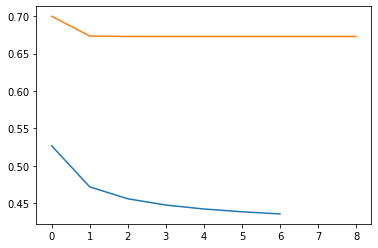

In [43]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'])
pyplot.plot(history_hyper.history['loss'])
pyplot.show()

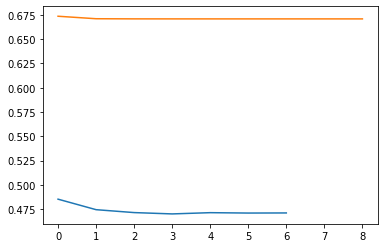

In [44]:
from matplotlib import pyplot

pyplot.plot(history.history['val_loss'])
pyplot.plot(history_hyper.history['val_loss'])
pyplot.show()

## Metrik #2: MAE

Nilai MAE merepresentasikan rata – rata kesalahan (error) absolut antara hasil peramalan dengan nilai sebenarnya.
Dengan menggunakan nilai yang mudah didapat, namun metrik yang sangat bermanfaat ini, dapat dilihat seberapa besar rata-rata dari kesalahan model dalam melakukan algoritmanya (melakukan prediksi). Semakin kecil nilai dari MAE, maka model berfungsi dengan baik.

MAE sendiri didapatkan dari seluruh prediksi dikurangkan dengan prediksi yang benar, dibagi dengan poin dalam prediksi. Melalui metrik ini, dapat diketahui seberapa besar kemungkinan model dalam melakukan prediksi yang salah.

Pemilihan MAE pada model ini dikarenakan MAE mudah duntuk diterapkan, serta memiliki tujuan yang linier dengan sistem rekomendasi, yaitu mencari kesalahan dari penggunaan model.

Berikut adalah hasil perbandingan MAE pada kedua model yang telah dibuat dalam grafik:

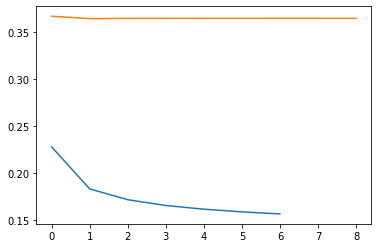

In [35]:
from matplotlib import pyplot

pyplot.plot(history.history['mae'])
pyplot.plot(history_hyper.history['mae'])
pyplot.show()

## Metrik #3: MSE

Hampir sama dengan MAE, MSE didapatkan dengan cara masing-masing kesalahan atau sisa dikuadratkan. Kemudian dijumlahkan dan ditambahkan dengan jumlah observasi. Pendekatan ini mengatur kesalahan peramalan yang besar karena kesalahan - kesalahan itu dikuadratkan.
Metode itu menghasilkan kesalahan-kesalahan sedang yang kemungkinan lebih baik untuk kesalahan kecil, tetapi kadang menghasilkan perbedaan yang besar.

Pemilihan metrik ini dalam sistem rekomendasi adalah karena MSE memiliki beberapa keunggulan seperti hasilnya mencakup kesalahan-kesalahan yang lebih besar dari MAE, sehingga dapat diketahui sebesar apa kemungkinan model akan melakukan kesalahan prediksi yang besar.

Berikut adalah hasil perbandingan MSE pada kedua model yang telah dibuat dalam grafik:

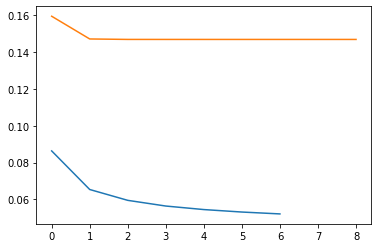

In [36]:
pyplot.plot(history.history['mse'])
pyplot.plot(history_hyper.history['mse'])
pyplot.show()

# KESIMPULAN

Dari pembuatan kedua model tersebut didapatkan hasil yang cukup optimal, dan sesuai dengan goal yang ingin dicapai, yaitu merekomendasikan beberapa judul anime yang memiliki kemiripan yang tinggi dengan anime yang diinputkan pertama kali.

**Dari proses pemodelan hingga evaluasi, dapat disimpulkan bahwa model #1 yang menggunakan RecommenderNet dan menggunakan optimizer Adam dapat melakukan tugas untuk memberikan rekomendasi anime dengan lebih baik dibandingkan model #2 yang pemodelannya menggunakan SGD optimizer yang dirancang sendiri oleh penulis.**